In [50]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler,StandardScaler
from sklearn.metrics import mean_squared_error,mean_absolute_error
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

In [51]:
np.random.seed(7)
dataset = pd.read_csv('tabela.csv', usecols=[1], engine='python', skipfooter=3)

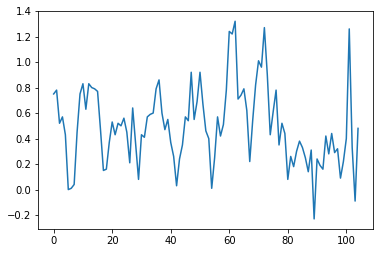

In [52]:
plt.plot(dataset)

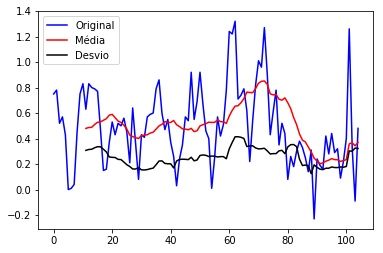

In [53]:
# Média e Desvio 
media  = pd.DataFrame.rolling(dataset, window=12).mean()
desvio = pd.DataFrame.rolling(dataset, window=12).std()
orig = plt.plot(dataset, color='blue',label='Original')
mean = plt.plot(media, color='red',label='Média')
std  = plt.plot(desvio, color='black',label='Desvio')
plt.legend(loc='best')

In [54]:
#Estimativa e Média Movel
k = 12 
media_mov = pd.DataFrame.rolling(dataset, k).mean()

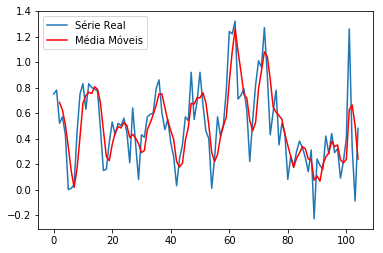

In [55]:
rolling = dataset.rolling(window=3)
rolling_mean = rolling.mean()
plt.plot(dataset, label='Série Real')
plt.plot(rolling_mean,color='red', label='Média Móveis')
plt.legend(loc='best')

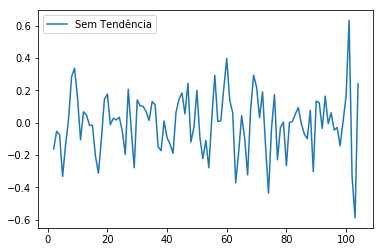

In [56]:
# Eliminando a tendência
dados_sazonalidade_ruido = dataset - rolling_mean
plt.plot(dados_sazonalidade_ruido, label='Sem Tendência')
plt.legend(loc='best')

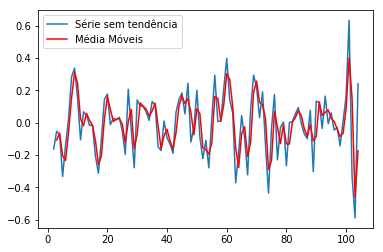

In [57]:
# Média móveis sem a tendência 
dados_sazonalidade_ruido
rolling = dados_sazonalidade_ruido.rolling(window=2)
rolling_mean = rolling.mean()
plt.plot(dados_sazonalidade_ruido, label='Série sem tendência')
plt.plot(rolling_mean,color='red', label='Média Móveis')
plt.legend(loc='best')

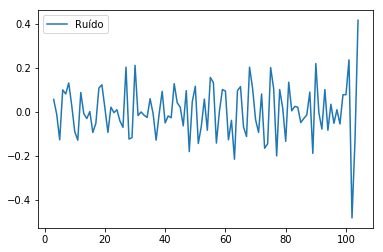

In [58]:
# Elimina sazonalidade
dados_ruido = dados_sazonalidade_ruido - rolling_mean 
plt.plot(dados_ruido, label='Ruído')
plt.legend(loc='best')

In [59]:
#Converte um array de valores em uma matrix
def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-1):
        dataX.append(dataset[i:(i+look_back), 0])
        dataY.append(dataset[i + look_back, 0])
    return np.array(dataX), np.array(dataY)

In [70]:
#Normalização dos dados
scaler = MinMaxScaler(feature_range=(0,1))
dataset = scaler.fit_transform(dataset)
resultadoLSTM, resultadoSVR, resultadoLR, resultadoDTR = [], [], [], []
numeroDeTrain = 30

In [71]:
# Model LSTM
def trainLSTM(dataset):
    #Split dos dados
    train_size = int(len(dataset) * 0.70)
    test_size = len(dataset) - train_size
    train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]
    # reshape into X=t and Y=t+1
    look_back = 12
    trainX, trainY = create_dataset(train, look_back)
    testX, testY = create_dataset(test, look_back)
    # reshape input to be [samples, time steps, features]
    trainXR = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
    testXR =  np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))
    
    # create and fit the LSTM network 
    from keras.models import Sequential
    from keras.layers import Dense
    from keras.layers import LSTM

    model = Sequential()
    model.add(LSTM(4, input_shape=(1, look_back)))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam')
    model.fit(trainXR, trainY, epochs=100, batch_size=1, verbose=False)

    #Make predictions
    trainPredictLSTM = model.predict(trainXR)
    testPredictLSTM = model.predict(testXR)
    #Invert predictions
    trainPredictLSTM = scaler.inverse_transform(trainPredictLSTM)
    trainYInv = scaler.inverse_transform([trainY])
    testPredictLSTM = scaler.inverse_transform(testPredictLSTM)
    testYInv = scaler.inverse_transform([testY])
    #Calculate root mean squared error
    testScoreLSTM = math.sqrt(mean_absolute_error(testYInv[0], testPredictLSTM[:,0]))
    print('Test Score: %.2f MAE' % (testScoreLSTM))
    resultadoLSTM.append(testScoreLSTM)
    return testScoreLSTM

for i in range(numeroDeTrain):
    print(f'Train: {(i + 1)}')
    trainLSTM(dataset)
    

mediaLSTM = np.mean(resultadoLSTM)

Train: 1
Test Score: 0.39 MAE
Train: 2
Test Score: 0.38 MAE
Train: 3
Test Score: 0.40 MAE
Train: 4
Test Score: 0.38 MAE
Train: 5
Test Score: 0.40 MAE
Train: 6
Test Score: 0.40 MAE
Train: 7
Test Score: 0.38 MAE
Train: 8
Test Score: 0.40 MAE
Train: 9
Test Score: 0.39 MAE
Train: 10
Test Score: 0.39 MAE
Train: 11
Test Score: 0.40 MAE
Train: 12
Test Score: 0.40 MAE
Train: 13
Test Score: 0.41 MAE
Train: 14
Test Score: 0.38 MAE
Train: 15
Test Score: 0.39 MAE
Train: 16
Test Score: 0.41 MAE
Train: 17
Test Score: 0.39 MAE
Train: 18
Test Score: 0.38 MAE
Train: 19
Test Score: 0.38 MAE
Train: 20
Test Score: 0.39 MAE
Train: 21
Test Score: 0.40 MAE
Train: 22
Test Score: 0.39 MAE
Train: 23
Test Score: 0.39 MAE
Train: 24
Test Score: 0.40 MAE
Train: 25
Test Score: 0.41 MAE
Train: 26
Test Score: 0.41 MAE
Train: 27
Test Score: 0.39 MAE
Train: 28
Test Score: 0.39 MAE
Train: 29
Test Score: 0.38 MAE
Train: 30
Test Score: 0.38 MAE


In [72]:
#Model SVR 
def trainSVR(dataset):
    #Split dos dados
    train_size = int(len(dataset) * 0.70)
    test_size = len(dataset) - train_size
    train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]
    # reshape into X=t and Y=t+1
    look_back = 12
    trainX, trainY = create_dataset(train, look_back)
    testX, testY = create_dataset(test, look_back)
    
    from sklearn.svm import SVR

    modeloSVR = SVR()
    modeloSVR.fit(trainX, trainY)
    # make predictions
    train_predict = modeloSVR.predict(trainX)
    test_predict = modeloSVR.predict(testX)
    testScoreSVR = mean_absolute_error(testY, test_predict)
    print('Test MAE: %.5f' % (testScoreSVR))
    resultadoSVR.append(testScoreSVR)
    return testScoreSVR

for i in range(numeroDeTrain):
    print(f'Train: {(i + 1)}')
    trainSVR(dataset)
    

mediaSVR = np.mean(resultadoSVR)

Train: 1
Test MAE: 0.19003
Train: 2
Test MAE: 0.19003
Train: 3
Test MAE: 0.19003
Train: 4
Test MAE: 0.19003
Train: 5
Test MAE: 0.19003
Train: 6
Test MAE: 0.19003
Train: 7
Test MAE: 0.19003
Train: 8
Test MAE: 0.19003
Train: 9
Test MAE: 0.19003
Train: 10
Test MAE: 0.19003
Train: 11
Test MAE: 0.19003
Train: 12
Test MAE: 0.19003
Train: 13
Test MAE: 0.19003
Train: 14
Test MAE: 0.19003
Train: 15
Test MAE: 0.19003
Train: 16
Test MAE: 0.19003
Train: 17
Test MAE: 0.19003
Train: 18
Test MAE: 0.19003
Train: 19
Test MAE: 0.19003
Train: 20
Test MAE: 0.19003
Train: 21
Test MAE: 0.19003
Train: 22
Test MAE: 0.19003
Train: 23
Test MAE: 0.19003
Train: 24
Test MAE: 0.19003
Train: 25
Test MAE: 0.19003
Train: 26
Test MAE: 0.19003
Train: 27
Test MAE: 0.19003
Train: 28
Test MAE: 0.19003
Train: 29
Test MAE: 0.19003
Train: 30
Test MAE: 0.19003


In [73]:
# Model LinearRegression 
def trainLinearRegression(dataset):
    #Split dos dados
    train_size = int(len(dataset) * 0.70)
    test_size = len(dataset) - train_size
    train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]
    # reshape into X=t and Y=t+1
    look_back = 12
    trainX, trainY = create_dataset(train, look_back)
    testX, testY = create_dataset(test, look_back)
    
    from sklearn.linear_model import LinearRegression

    modeloLinearRegression = LinearRegression()
    modeloLinearRegression.fit(trainX, trainY)
    # make predictions
    trainPredict = modeloLinearRegression.predict(trainX)
    testPredict = modeloLinearRegression.predict(testX)
    testScoreLR = mean_absolute_error(testY, testPredict)
    print('Test MAE: %.5f' % (testScoreLR))
    resultadoLR.append(testScoreLR)
    return testScoreLR

for i in range(numeroDeTrain):
    print(f'Train: {(i + 1)}')
    trainLinearRegression(dataset)
    
    
mediaLR = np.mean(resultadoLR)

Train: 1
Test MAE: 0.16590
Train: 2
Test MAE: 0.16590
Train: 3
Test MAE: 0.16590
Train: 4
Test MAE: 0.16590
Train: 5
Test MAE: 0.16590
Train: 6
Test MAE: 0.16590
Train: 7
Test MAE: 0.16590
Train: 8
Test MAE: 0.16590
Train: 9
Test MAE: 0.16590
Train: 10
Test MAE: 0.16590
Train: 11
Test MAE: 0.16590
Train: 12
Test MAE: 0.16590
Train: 13
Test MAE: 0.16590
Train: 14
Test MAE: 0.16590
Train: 15
Test MAE: 0.16590
Train: 16
Test MAE: 0.16590
Train: 17
Test MAE: 0.16590
Train: 18
Test MAE: 0.16590
Train: 19
Test MAE: 0.16590
Train: 20
Test MAE: 0.16590
Train: 21
Test MAE: 0.16590
Train: 22
Test MAE: 0.16590
Train: 23
Test MAE: 0.16590
Train: 24
Test MAE: 0.16590
Train: 25
Test MAE: 0.16590
Train: 26
Test MAE: 0.16590
Train: 27
Test MAE: 0.16590
Train: 28
Test MAE: 0.16590
Train: 29
Test MAE: 0.16590
Train: 30
Test MAE: 0.16590


In [74]:
# DecisionTreeRegressor
def trainDecisionTreeRegressor(dataset):
    #Split dos dados
    train_size = int(len(dataset) * 0.70)
    test_size = len(dataset) - train_size
    train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]
    # reshape into X=t and Y=t+1
    look_back = 12
    trainX, trainY = create_dataset(train, look_back)
    testX, testY = create_dataset(test, look_back)
    
    from sklearn.tree import DecisionTreeRegressor
    
    tree = DecisionTreeRegressor(criterion='mae')
    tree.fit(trainX, trainY)
    # make predictions
    trainPredict = tree.predict(trainX)
    testPredict = tree.predict(testX)
    testScoreDTR = mean_absolute_error(testY, testPredict)
    print('Test MAE: %.5f' % (testScoreDTR))
    resultadoDTR.append(testScoreDTR)
    return testScoreDTR

for i in range(numeroDeTrain):
    print(f'Train: {(i + 1)}')
    trainDecisionTreeRegressor(dataset)
    
    
mediaDTR = np.mean(resultadoDTR)

Train: 1
Test MAE: 0.16570
Train: 2
Test MAE: 0.16231
Train: 3
Test MAE: 0.16604
Train: 4
Test MAE: 0.16333
Train: 5
Test MAE: 0.18132
Train: 6
Test MAE: 0.16537
Train: 7
Test MAE: 0.18302
Train: 8
Test MAE: 0.16197
Train: 9
Test MAE: 0.17046
Train: 10
Test MAE: 0.16469
Train: 11
Test MAE: 0.17419
Train: 12
Test MAE: 0.16978
Train: 13
Test MAE: 0.17555
Train: 14
Test MAE: 0.18438
Train: 15
Test MAE: 0.16842
Train: 16
Test MAE: 0.16299
Train: 17
Test MAE: 0.17351
Train: 18
Test MAE: 0.16672
Train: 19
Test MAE: 0.18098
Train: 20
Test MAE: 0.16978
Train: 21
Test MAE: 0.17317
Train: 22
Test MAE: 0.16129
Train: 23
Test MAE: 0.16469
Train: 24
Test MAE: 0.16706
Train: 25
Test MAE: 0.18268
Train: 26
Test MAE: 0.18132
Train: 27
Test MAE: 0.16367
Train: 28
Test MAE: 0.16333
Train: 29
Test MAE: 0.16876
Train: 30
Test MAE: 0.16672


In [76]:
#Combinação de modelos
#Modelos usados - LSTM, SVR, LinearRegression, DecisionTreeRegression
mediaCombinada = np.mean((mediaLSTM, mediaSVR, mediaLR, mediaDTR), dtype=np.float64) 
print("Média Combinada ")
print(mediaCombinada)

Média Combinada 
0.2298991191528759


In [99]:
dados = {
    "LSTM": [mediaLSTM], 
    "SVR": [mediaSVR], 
    "LinearRegression": [mediaLR], 
    "DecisionTreeRegression": [mediaDTR],
    "COMBINADA": [mediaCombinada]
}
media = pd.DataFrame(dados)

In [100]:
media

,LSTM,SVR,LinearRegression,DecisionTreeRegression,COMBINADA
0,0.393557,0.190035,0.165897,0.170108,0.229899
